# NLP model that predics if a tweet describes a natural disaster
## Problem description
I have the dataset attached to this competition from kaggle: https://www.kaggle.com/competitions/nlp-getting-started which has tweets that can describe a natural disaster. In the training dataset, those the tweets that describe natural disasters have the target value equal to 1, the others that do not have the target value equal to 0. The objective of this model is to predict with tweets can describe natural disasters.

## Steps
* Preprocess the tweets (lowercase all the words, remove links, remove punctuation, remove stop words)
* Sentiment analysis: adding a sentiment label to each tweet could improve the model's accuracy
* Tokenize the text
* Build different models and pick the one with the highest accuracy

## Imports
These are imports useful for data processing.

In [2]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
import spacy
from transformers import pipeline
import numpy as np
from nltk.corpus import stopwords
import datasets as dt
from transformers.pipelines.pt_utils import KeyDataset

## Text preprocessing
In this step I will make function that will preprocess the tweets from the dataset. These function will later be used in a pandas pipeline. I chose this approach so I can easly change the order of preprocessing and easily add new steps.

In [3]:
def insert_columns(dataset: pd.DataFrame, columns: list[tuple[int, str]]) -> pd.DataFrame:
    for column in columns:
        dataset.insert(loc=column[0], column=column[1], value=np.nan)
    print(f"Inserted {len(columns)} columns.\n")
    return dataset
insert_columns

<function __main__.insert_columns(dataset: pandas.core.frame.DataFrame, columns: list[tuple[int, str]]) -> pandas.core.frame.DataFrame>

In [4]:
def copy_column_data(dataset: pd.DataFrame, source: str, destination: str) -> pd.DataFrame:
    dataset[destination] = dataset[source]
    print(f"Copied data from {source} to {destination}.\n")
    return dataset
copy_column_data

<function __main__.copy_column_data(dataset: pandas.core.frame.DataFrame, source: str, destination: str) -> pandas.core.frame.DataFrame>

In [5]:
def lower_case_text_columns(dataset: pd.DataFrame, columns: list[str],) -> pd.DataFrame:
    for column in columns:
        try:
            dataset[column] = [text.lower() for text in dataset[column]]
        except Exception as e:
            print(e)
    print(f"Lowercased words in {columns}.\n")
    return dataset
lower_case_text_columns

<function __main__.lower_case_text_columns(dataset: pandas.core.frame.DataFrame, columns: list[str]) -> pandas.core.frame.DataFrame>

In [6]:
def remove_pattern(dataset: pd.DataFrame, pattern: str, column: str,) -> pd.DataFrame:
    try:
        dataset[column] = [re.sub(pattern=pattern, repl="", string=text) for text in dataset[column]]
    except Exception as e:
        print(e)
    print(f"Removed pattern: {pattern}\n")
    return dataset
remove_pattern

<function __main__.remove_pattern(dataset: pandas.core.frame.DataFrame, pattern: str, column: str) -> pandas.core.frame.DataFrame>

In [7]:
def remove_words(dataset: pd.DataFrame, words_list: list[str], column: str,) -> pd.DataFrame:
    dataset[column] = [" ".join([word for word in text.split() if word not in words_list]) for text in dataset[column]]
    print("Removed words.\n")
    return dataset
remove_words

<function __main__.remove_words(dataset: pandas.core.frame.DataFrame, words_list: list[str], column: str) -> pandas.core.frame.DataFrame>

In [8]:
def tokenize_text(dataset: pd.DataFrame, column: str,) -> pd.DataFrame:
    dataset[column] = [word_tokenize(text) for text in dataset[column]]
    print(f"Tokenized text from column: {column}\n")
    return dataset
tokenize_text

<function __main__.tokenize_text(dataset: pandas.core.frame.DataFrame, column: str) -> pandas.core.frame.DataFrame>

In [9]:
def lemmatize_words(dataset: pd.DataFrame, column: str,) -> pd.DataFrame:
    lemmitizer = WordNetLemmatizer()
    final_texts = []
    for text in dataset[column]:
        lemmatized_text = []
        for word in text:
            lemmatized_text.append(lemmitizer.lemmatize(word))
        final_texts.append(lemmatized_text)
    dataset[column] = final_texts
    print(f"Lemmatiezed text from column: {column}\n")
    return dataset
lemmatize_words

<function __main__.lemmatize_words(dataset: pandas.core.frame.DataFrame, column: str) -> pandas.core.frame.DataFrame>

In [10]:
def stem_words(dataset: pd.DataFrame, column: str,) -> pd.DataFrame:
    stemmer = PorterStemmer()
    dataset[column] = [stemmer.stem(word) for text in dataset[column] for word in text]
    print(f"Stemmed text from column: {column}\n")
    return dataset
stem_words

<function __main__.stem_words(dataset: pandas.core.frame.DataFrame, column: str) -> pandas.core.frame.DataFrame>

In [11]:
def sentiment_analysis(dataset: pd.DataFrame, text_column: str, label_column: str, model_name: str) -> pd.DataFrame:
    sentiment_pipeline = pipeline('sentiment-analysis', model=model_name, device=0)
    tweets = dataset[text_column].values.tolist()
    sentiment_list = sentiment_pipeline(tweets, batch_size=128)
    dataset[label_column] = [sent['label'] for sent in sentiment_list]
    return dataset
sentiment_analysis

<function __main__.sentiment_analysis(dataset: pandas.core.frame.DataFrame, text_column: str, label_column: str, model_name: str) -> pandas.core.frame.DataFrame>

## Data analysis
In this step I will generate a few graphs to visualize the patterns from the data.

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
words = stopwords.words('english')

Before generating the graphs, the data will be processed so it will be easier to get the patterns from it.

In [13]:
train_dataset = pd.read_csv(r'data\train.csv', index_col=0)
train_1 = (train_dataset.pipe(insert_columns, columns=[(3, 'preprocessed'), (4, 'sentiment')])
                 .pipe(copy_column_data, source='text', destination='preprocessed')
                 .pipe(lower_case_text_columns, columns=['preprocessed'])
                 .pipe(remove_pattern, pattern=r"https?://\S", column='preprocessed')
                 .pipe(remove_pattern, pattern=r"[^\s\w]", column='preprocessed') 
                 .pipe(sentiment_analysis, text_column='preprocessed', label_column='sentiment', model_name='finiteautomata/bertweet-base-sentiment-analysis') 
                 .pipe(remove_words, words_list=words, column='preprocessed') 
                 .pipe(tokenize_text, column='preprocessed') 
                 .pipe(lemmatize_words, column='preprocessed') 
            )
train_1.head(5)

Inserted 2 columns.

Copied data from text to preprocessed.

Lowercased words in ['preprocessed'].

Removed pattern: https?://\S

Removed pattern: [^\s\w]



emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cuda:0


Removed words.

Tokenized text from column: preprocessed

Lemmatiezed text from column: preprocessed



,keyword,location,text,preprocessed,sentiment,target
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,"[deed, reason, earthquake, may, allah, forgive...",NEU,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]",NEU,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,"[resident, asked, shelter, place, notified, of...",NEU,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","[13000, people, receive, wildfire, evacuation,...",NEU,1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,"[got, sent, photo, ruby, alaska, smoke, wildfi...",NEU,1


### Sentiment distribution

C:\Users\teodo\AppData\Local\Temp\ipykernel_34192\3767133524.py:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


<Axes: xlabel='target', ylabel='count'>

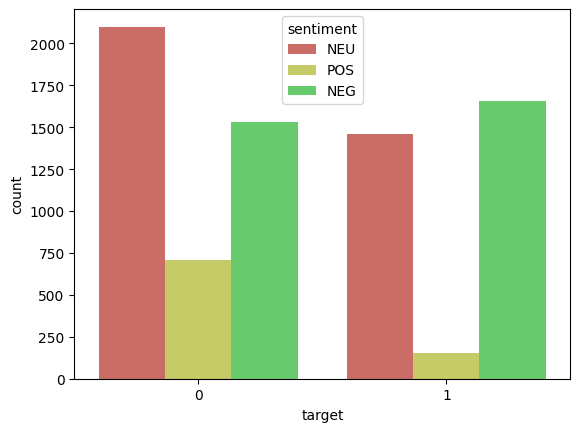

In [14]:
sent_dist = train_1.loc[:, ['sentiment', 'target']]
plt.figure()
sns.countplot(
    x='target',
    hue='sentiment',
    palette=sns.color_palette('hls'),
    data=sent_dist
)


The sentiment analysis done by the `finiteautomata/bertweet-base-sentiment-analysis` shows that the tweets that describe natural disasters have either a negative sentiment or a neutral one, few having a positive one. On the other hand, the tweets that do not describe natural disasters tend to have a neutral sentiment. Although both categories have almost the same amount of negative tweets, the positive tweets tend to not describe a natural disaster.

I'm going to create a new panas pipe, but this time the sentiment analysis will be done by `tabularisai/multilingual-sentiment-analysis`. This model has 5 labels: Very Negative, Negative, Neutral, Positive, Very Positive.

In [15]:
train_dataset = pd.read_csv(r'data\train.csv', index_col=0)
train_2 = (train_dataset.pipe(insert_columns, columns=[(4, 'preprocessed_2'), (5, 'sentiment_2')])
                 .pipe(copy_column_data, source='text', destination='preprocessed_2')
                 .pipe(lower_case_text_columns, columns=['preprocessed_2'])
                 .pipe(remove_pattern, pattern=r"https?://\S", column='preprocessed_2')
                 .pipe(remove_pattern, pattern=r"[^\s\w]", column='preprocessed_2') 
                 .pipe(sentiment_analysis, text_column='preprocessed_2', label_column='sentiment_2', model_name='tabularisai/multilingual-sentiment-analysis') 
                 .pipe(remove_words, words_list=words, column='preprocessed_2') 
                 .pipe(tokenize_text, column='preprocessed_2') 
                 .pipe(lemmatize_words, column='preprocessed_2') 
            )
train_2.head(5)

Inserted 2 columns.

Copied data from text to preprocessed_2.

Lowercased words in ['preprocessed_2'].

Removed pattern: https?://\S

Removed pattern: [^\s\w]



Device set to use cuda:0


Removed words.

Tokenized text from column: preprocessed_2

Lemmatiezed text from column: preprocessed_2



,keyword,location,text,target,preprocessed_2,sentiment_2
id,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquake, may, allah, forgive...",Very Positive
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",Neutral
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[resident, asked, shelter, place, notified, of...",Neutral
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13000, people, receive, wildfire, evacuation,...",Neutral
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",Neutral


C:\Users\teodo\AppData\Local\Temp\ipykernel_34192\1213547169.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(


<Axes: xlabel='target', ylabel='count'>

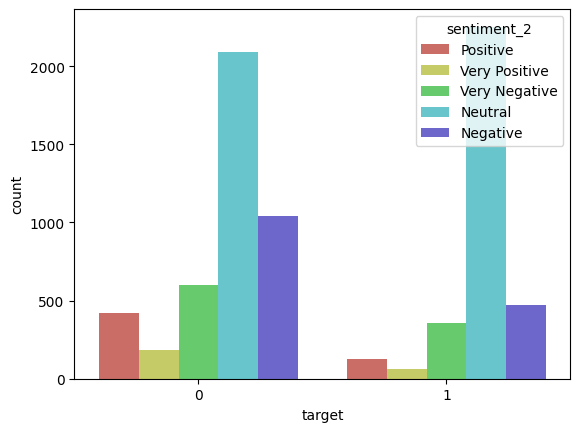

In [16]:
sent_dist = train_2.loc[:, ['sentiment_2', 'target']]
plt.figure()
sns.countplot(
    x='target',
    hue='sentiment_2',
    palette=sns.color_palette('hls'),
    data=sent_dist
)

The model `tabularisai/multilingual-sentiment-analysis` shows that both categories have mostly neutral tweets. Also, it seems that here the positive tweets are few among the ones that describe natural disasters.
As a conclusion, sentiment analysis can be used in training the model since the tweets that describe natural disasters tend to be neutral or negative, and very rarely positive.

### N-grams
In this step I will generate some ngrams to see what are the most common phrases found in the dataset.

Text(0.5, 1.0, 'Top 10 most common 2 word phrases')

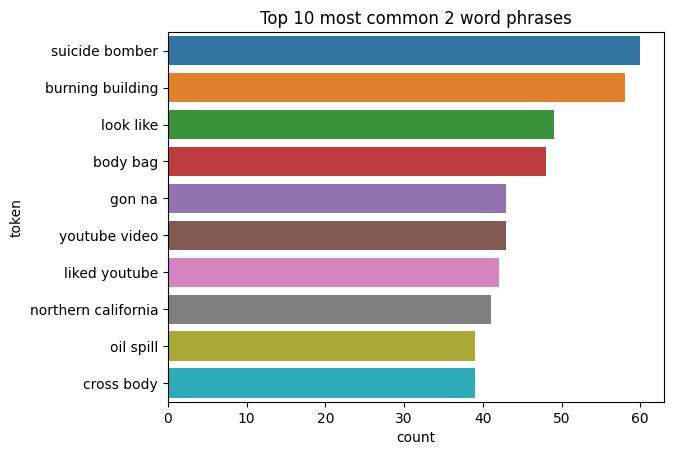

In [17]:
data = sum(train_1['preprocessed'], [])
ngram_2 = (pd.Series(nltk.ngrams(data, 2)).value_counts())
ngram_2 = pd.DataFrame(ngram_2)
index_list = []
for index in ngram_2.index:
    index = str(index)
    index = re.sub(r'[^\s\w]', "", index)
    index_list.append(index)
ngram_2.index = index_list
ngram_2['token'] = index_list
plt.figure()
sns.barplot(x='count',
            y='token',
            data=ngram_2.head(10),
            hue='token',
            orient='h').set_title('Top 10 most common 2 word phrases')

The graph from above shown that the most frequent bigramns are "suicide bomber" and "burning building". This could indicate that a lot of the disasters described are related to terrorist attacks and fires.

Text(0.5, 1.0, 'Top 10 most common 3 word phrases')

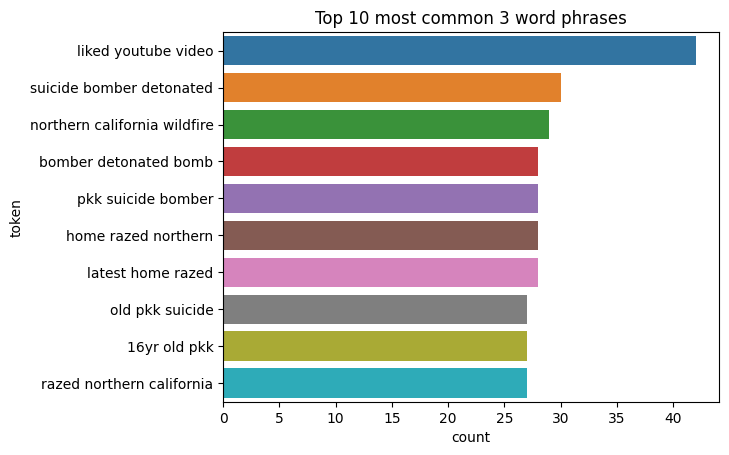

In [18]:
ngram_3 = (pd.Series(nltk.ngrams(data, 3)).value_counts())
ngram_3 = pd.DataFrame(ngram_3)
index_list = []
for index in ngram_3.index:
    index = str(index)
    index = re.sub(r'[^\s\w]', "", index)
    index_list.append(index)
ngram_3.index = index_list
ngram_3['token'] = index_list
plt.figure()
sns.barplot(x='count',
            y='token',
            data=ngram_3.head(10),
            hue='token',
            orient='h').set_title('Top 10 most common 3 word phrases')

The trigams show that a lot of tweets from the dataset are about youtube videos but the ones related to the disasters are suicide bombers, wildfires and destroyed houses in California.

Text(0.5, 1.0, 'Top 10 most common 4 word phrases')

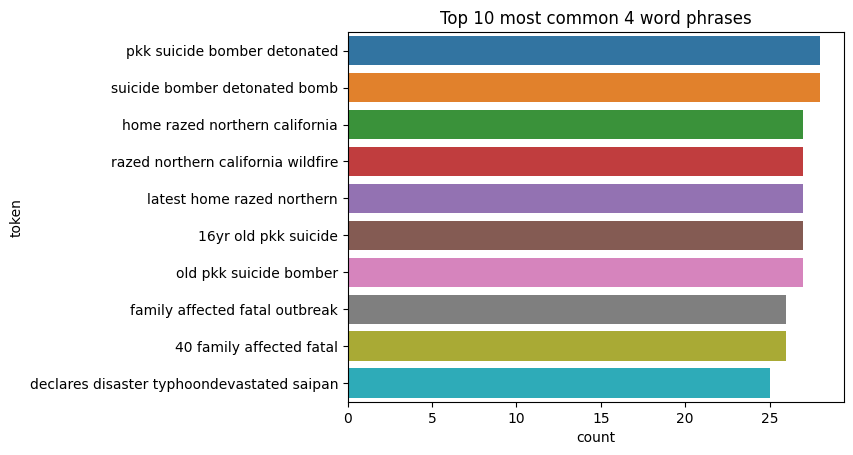

In [19]:
ngram_4 = (pd.Series(nltk.ngrams(data, 4)).value_counts())
ngram_4 = pd.DataFrame(ngram_4)
index_list = []
for index in ngram_4.index:
    index = str(index)
    index = re.sub(r'[^\s\w]', "", index)
    index_list.append(index)
ngram_4.index = index_list
ngram_4['token'] = index_list
plt.figure()
sns.barplot(x='count',
            y='token',
            data=ngram_4.head(10),
            hue='token',
            orient='h').set_title('Top 10 most common 4 word phrases')

Again, we see that a lot of tweets describe terrorist attacks, destroyed houses and wildfires.

## Creating and training models

In [20]:
X = [",".join(map(str, l)) for l in train_1['preprocessed']]
y = train_1['target']

To transform the words into numbers I will use to methods: bag of words and tf idf.

###  Preparing data - Bag of words

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

vectorizer = CountVectorizer()
vect_fit = vectorizer.fit_transform(X)
bog_no_sent = pd.DataFrame(vect_fit.toarray(), columns=vectorizer.get_feature_names_out()) # bag of words without the sentiment analysis
bog_no_sent.index = train_1.index

bog_sent_1 = bog_no_sent.copy()
bog_sent_1['sentiment_'] = train_1.sentiment.values

bog_sent_2 = bog_no_sent.copy()
bog_sent_2['sentiment_'] = train_2.sentiment_2.values

encoder_1 = OrdinalEncoder(categories=[['POS', 'NEU', 'NEG']])
encoder_2 = OrdinalEncoder(categories=[['Very Positive', 'Positive', 'Very Negative', 'Negative', 'Neutral']])
X_no_sent_train, X_no_sent_valid, y_no_sent_train, y_no_sent_valid = train_test_split(bog_no_sent, y, random_state=0)
X_sent_1_train, X_sent_1_valid, y_sent_1_train, y_sent_1_valid = train_test_split(bog_sent_1, y, random_state=1)
X_sent_2_train, X_sent_2_valid, y_sent_2_train, y_sent_2_valid = train_test_split(bog_sent_2, y, random_state=2)

X_sent_1_train['sentiment_'] = encoder_1.fit_transform(X_sent_1_train[['sentiment_']])
X_sent_1_valid['sentiment_'] = encoder_1.transform(X_sent_1_valid[['sentiment_']])

X_sent_2_train['sentiment_'] = encoder_2.fit_transform(X_sent_2_train[['sentiment_']])
X_sent_2_valid['sentiment_'] = encoder_2.transform(X_sent_2_valid[['sentiment_']])

### Training models with bag of words

#### LogisticRegression 

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

no_sent_model = LogisticRegression(random_state=10)
no_sent_model.fit(X_no_sent_train, y_no_sent_train)
pred_1 = no_sent_model.predict(X_no_sent_valid)
accuracy_1 = accuracy_score(y_no_sent_valid, pred_1)
print("Logistic Regression model train without sentiment analysis:", accuracy_1)

Logistic Regression model train without sentiment analysis: 0.8109243697478992


In [23]:
sent_1_model = LogisticRegression(random_state=20)
sent_1_model.fit(X_sent_1_train, y_sent_1_train)
pred_2 = sent_1_model.predict(X_sent_1_valid)
accuracy_2 = accuracy_score(y_sent_1_valid, pred_2)
print("Logistic Regression model training with seniment analysis:", accuracy_2)

Logistic Regression model training with seniment analysis: 0.7925420168067226


In [24]:
sent_2_model = LogisticRegression(random_state=30)
sent_2_model.fit(X_sent_2_train, y_sent_2_train)
pred_3 = sent_2_model.predict(X_sent_2_valid)
accuracy_3 = accuracy_score(y_sent_2_valid, pred_3)
print("Logistic Regression model training with seniment analysis:", accuracy_3)

Logistic Regression model training with seniment analysis: 0.7888655462184874


Looking at the acurracy scores from above we can say that Logistic Regression model was more accurate without sentiment analysis

#### Linear Support Vector Machine

In [25]:
from sklearn.linear_model import SGDClassifier

svm_model = SGDClassifier()
svm_model.fit(X_no_sent_train, y_no_sent_train)
pred_4 = svm_model.predict(X_no_sent_valid)
accuracy_4 = accuracy_score(y_no_sent_valid, pred_4)
print('Linear Support Vector Machine model without sentiment analysis:', accuracy_4)

Linear Support Vector Machine model without sentiment analysis: 0.7899159663865546


In [26]:
svm_model_2 = SGDClassifier()
svm_model_2.fit(X_sent_1_train, y_sent_1_train)
pred_5 = svm_model_2.predict(X_sent_1_valid)
accuracy_5 = accuracy_score(y_sent_1_valid, pred_5)
print('Linear Support Vector Machine model with sentiment analysis:', accuracy_5)

Linear Support Vector Machine model with sentiment analysis: 0.7710084033613446


In [27]:
svm_model_3 = SGDClassifier()
svm_model_3.fit(X_sent_2_train,y_sent_2_train)
pred_6 = svm_model_3.predict(X_sent_2_valid)
accuracy_6 = accuracy_score(y_sent_2_valid, pred_6)
print('Linear Support Vector Machine model with sentiment analysis:', accuracy_6)

Linear Support Vector Machine model with sentiment analysis: 0.7584033613445378


From these models, we can see that only the Logistic Regression model trained with only a bag of words has the highest accuracy.

In [28]:
no_sent_model

LogisticRegression(random_state=10)

In [29]:
accuracy_1

0.8109243697478992

In [36]:
test_data = pd.read_csv(r'data\test.csv', index_col=0)
test_data = (test_data.pipe(insert_columns, columns=[(3, 'preprocessed')])
                 .pipe(copy_column_data, source='text', destination='preprocessed')
                 .pipe(lower_case_text_columns, columns=['preprocessed'])
                 .pipe(remove_pattern, pattern=r"https?://\S", column='preprocessed')
                 .pipe(remove_pattern, pattern=r"[^\s\w]", column='preprocessed') 
                 .pipe(remove_words, words_list=words, column='preprocessed') 
                 .pipe(tokenize_text, column='preprocessed') 
                 .pipe(lemmatize_words, column='preprocessed') 
            )
test_data.head(5)

Inserted 1 columns.

Copied data from text to preprocessed.

Lowercased words in ['preprocessed'].

Removed pattern: https?://\S

Removed pattern: [^\s\w]

Removed words.

Tokenized text from column: preprocessed

Lemmatiezed text from column: preprocessed



,keyword,location,text,preprocessed
id,,,,
0,NaN,NaN,Just happened a terrible car crash,"[happened, terrible, car, crash]"
2,NaN,NaN,"Heard about #earthquake is different cities, s...","[heard, earthquake, different, city, stay, saf..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, goose, fleeing, acr..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, spokane, wildfire]"
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kill, 28, china, taiwan]"


In [37]:
test_input = [",".join(map(str, l)) for l in test_data['preprocessed']]
test_vec_fit = vectorizer.transform(test_input)
bow_test = pd.DataFrame(test_vec_fit.toarray(), columns=vectorizer.get_feature_names_out())
bow_test.index = test_data.index

prediction = no_sent_model.predict(bow_test)

output = pd.DataFrame({'id': bow_test.index, 'target': prediction})
output.to_csv(r'results\log_reg_bow.csv', index=False)

### Preparing data - TF IDF

Since the best result for a model trained with a bag of words was from a Logistic Regression model trained only with a bag of words (without any sentiment analysis), here only a Logistic Regression model will be used.

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
tfidf_fit = tfidf_vect.fit_transform(X)
tfidf_data = pd.DataFrame(tfidf_fit.toarray(), columns=tfidf_vect.get_feature_names_out())

X_train, X_valid, y_train, y_valid = train_test_split(tfidf_data, y, random_state=42)


### Creating the model

In [40]:
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, pred)
print("Logistic Regression model trained with tf idf data:", accuracy)

Logistic Regression model trained with tf idf data: 0.803046218487395


When trained with a bag of words, the model had the accuracy equal to 0.81 and when the model was train with tf idf the accuracy was 0.80. In conclusion, both approaches on encoding the data were good and sentiment analysis only lowered the accuracy.

In [42]:
tfidf_test_fit = tfidf_vect.transform(test_input)
tfidf_test_data = pd.DataFrame(tfidf_test_fit.toarray(), columns=tfidf_vect.get_feature_names_out())
prediction_2 = model.predict(tfidf_test_data)
output_2 = pd.DataFrame({'id': test_data.index, 'target': prediction_2})
output_2.to_csv(r'results\log_reg_tfidf.csv', index=False)